# Valve Position Prediction Project
This project is aimed at using the behaviour of a `PID regulator` based control system obtained from `Matlab`
to predict the opening level of the actuating mechanism (i.e. the valve) through various regressors such as `RandomForestRegressor` and `CatBoostRegressor`.
## 1. Problem definition
> How well can a valve's position be predicted using the data obtained from a Matlab simulation of a PID based control system
## 2. Data
> We have data from Matlab-Simulink based models of a PID based liquid level control system at `training_data_from_matlab2.csv`
* The dataset has timestamps in `seconds` format.
* It has the desired input levels of the liquid in meters.
* The output liquid levels in meters as well
* The feedback: The difference the desired output (input) and the actual output.
* Opening levels of the valve in % (0-100)
### 2.1. How to format the data
* We need to check what kind of format, the data under label `Time` are in and then convert them into either datetime.seconds or int64 format
* Convert `string` datatypes to float using `pd.to_numeric(downcast = 'float')`
* Eliminate any missing data by first generating `is_missing` boolean data for each column of the input data
* Then eliminate by checking through `isna().sum()` and `_is_missing.value_counts()` and then eliminating the missing values by replacing them with `medians`
* Eliminate erronious data. I.e. liquid levels above `1.0` in `input` and `liquid_level` columns and valve opening levels above `100` in `valve_positions` by replacing them with medians.
## 3. Modelling
* Use `train_test_split()` from `sklearn` to divide the dataset into training and validation datasets.
* Use `RandomForestRegressor` to train the model using the training dataset.
* Use `CatBoostRegressor` to train the model using the training dataset.
* Use `RandomizedSearchCV` to get the optimize the model using the best hyperparameters `RandomForestRegressor`
* Use `catboostcv` to obtain best hyperparameters for `CatBoostRegressor`
* Evaluate the optimized model on the validation datasets.
* Use test datasets to check the predictions of the model against true labels.

## 2. Data preparation
* In this part, we are going to import `training_data_from_matlab6.csv`.
* Check out what kind of format, the `Time` data is in and convert it into either int64 or `datetime(format = "seconds")`
* After that, we are to check for any other `string` type data using `pd.api.dtypes.is_string_dtype()` function. And convert all string type data to numeric, using`pd.to_numeric(downcast='float')`
* After converting all of the content of the dataframe except for *DateTime* we will check for missing data using `pd.isnull()`
* If found, then the missing data is to be replaced by zero.
* Once missing data is filled, we will be checking for values more than 100 in `Valve_positions` and values more than 1000 in `Liquid_levels`.
* This is errroneous data and it is to be replaced by the median values of the above mentioned labels.
* We will make a copy of the preprocessecd dataframe and label it as `df_for_modelling`
* In `df_for_modelling`, we will extract the year, month, date, hour, minute and seconds data from the DateTime column and then drop the datetime column as it can't be used for training a Regressor model.
* We are ready for modelling!

In [3]:
# Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
%matplotlib inline

In [4]:
df_raw_2 = pd.read_csv("training_data_from_matlab6.csv", low_memory=False)
# Make a copy of the raw dataframe before going on with something else
df_modified_data = df_raw_2.copy()
df_modified_data.info()
df_modified_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25853 entries, 0 to 25852
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             25853 non-null  object 
 1   Input            25853 non-null  float64
 2   Liquid_levels    25853 non-null  float64
 3   Feedback         25853 non-null  float64
 4   Valve_Positions  25853 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1010.0+ KB


,Time,Input,Liquid_levels,Feedback,Valve_Positions
0,0 sec,0.0,0.000000e+00,0.000000,0.000000
1,250 sec,0.0,0.000000e+00,0.000000,0.000000
2,250 sec,0.8,0.000000e+00,0.800000,66.417308
3,250 sec,0.8,1.394661e-13,0.800000,66.417308
4,252.34 sec,0.8,1.860182e-01,0.613982,82.258628


In [5]:
# Let's try converting this Time column to datetime/timedelta
df_modified_data["Time"] = df_modified_data["Time"].str.replace(" sec", "", regex=True)


In [6]:
# Now that the data under the column "Time" can now probably be converted to numeric dtypes
df_modified_data["Time"] = pd.to_numeric(df_modified_data["Time"])

In [7]:
df_modified_data["TimeDelta"] = pd.to_timedelta(df_modified_data.Time, unit = 's')

In [8]:
df_modified_data.head()

,Time,Input,Liquid_levels,Feedback,Valve_Positions,TimeDelta
0,0.00,0.0,0.000000e+00,0.000000,0.000000,0 days 00:00:00
1,250.00,0.0,0.000000e+00,0.000000,0.000000,0 days 00:04:10
2,250.00,0.8,0.000000e+00,0.800000,66.417308,0 days 00:04:10
3,250.00,0.8,1.394661e-13,0.800000,66.417308,0 days 00:04:10
4,252.34,0.8,1.860182e-01,0.613982,82.258628,0 days 00:04:12.340000


In [9]:
df_modified_2 = df_modified_data.copy()

In [10]:
df_modified_2.drop("TimeDelta", axis = 1, inplace = True)

In [11]:
df_modified_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25853 entries, 0 to 25852
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             25853 non-null  float64
 1   Input            25853 non-null  float64
 2   Liquid_levels    25853 non-null  float64
 3   Feedback         25853 non-null  float64
 4   Valve_Positions  25853 non-null  float64
dtypes: float64(5)
memory usage: 1010.0 KB


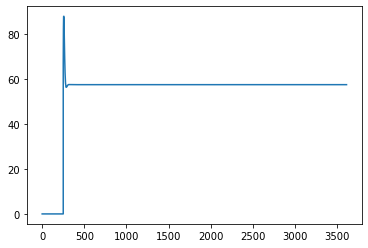

In [12]:
fig, ax = plt.subplots()
ax.plot(df_modified_2.Time[:300], df_modified_2.Valve_Positions[:300]);

In [13]:
# We know that all of these are numeric dtypes but still we will check for any string dtype remaining
for label, content in df_modified_2.items():
    if pd.api.types.is_string_dtype(content):
        print("There are string types in: ", label)
    else:
        print("There are no strings in :", label)

There are no strings in : Time
There are no strings in : Input
There are no strings in : Liquid_levels
There are no strings in : Feedback
There are no strings in : Valve_Positions


In [14]:
# Check for invalid/empty data
for label, content in df_modified_2.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print("There are NaNs in: ", label)
            df_modified_2[label + "is_missing"] = pd.isnull(content)
            df_modified_2[label] = content.fillna(0)
        else:
            print("There are no missing values in: ", label)
        

There are no missing values in:  Time
There are no missing values in:  Input
There are no missing values in:  Liquid_levels
There are no missing values in:  Feedback
There are no missing values in:  Valve_Positions


In [15]:
# Check for erroneous data in Liquid_levels
for content in df_modified_2.Liquid_levels:
    if (content > 1.25):
        print("Erroneous value found! ", content)
        content = df_modified_2.Liquid_levels.median()

# Check for erroneous data in Valve_positions
for content in df_modified_2.Valve_Positions:
    if (content > 100.0):
        print("Erroneous data found! ", content)
        content = df_modified_2.Valve_Positions.median()
np.max(df_modified_2.Liquid_levels), np.max(df_modified_2.Valve_Positions)    

(0.862643337266345, 88.0234256553024)

In [16]:
# We are prepared for modelling
X = df_modified_2.drop("Valve_Positions", axis = 1)
y = df_modified_2["Valve_Positions"]
X_train, X_val, y_train, y_val = train_test_split(X,y,
                                                      test_size=0.2)
model = RandomForestRegressor(n_jobs = -1,
                              random_state=45)

In [17]:
%%time
# let's try fittig once more
model.fit(X_train, y_train)

Wall time: 687 ms


RandomForestRegressor(n_jobs=-1, random_state=45)

In [18]:
val_preds = model.predict(X_val)


In [19]:
model.score(X_val, y_val)

0.8598832133809731

In [20]:
model.score(X_train, y_train)

0.9403403702206109

### Preparation of a function to preprocess data
* We will train the model on the entire dataset
* We will be able to train the model on timestamps
* To make the preprocessing easier, we will develop a preprocessing function


In [39]:
# Develop a file path
FILE_PATH = "training_data_from_matlab5.csv"

def preprocess_data(PROVIDED_FILE_PATH):
    """
    This function is meant to predict the opening level of a valve on the basis of input data, feedback data and timestamps
    The data is to be imported from the datasheets as specified in "FILE_PATH"
    The file will imported to a pandas dataframe
    The time data is to be converted from string to numeric
    A check will be performed to remove string type data, which is to be converted to float type
    Then a check will be performed for any missing data
    Then erroneous data (liquid levels > 1.2 and valve positions > 100) will be replaced with the median values of the respective columns
    The dataframe will be ready for further action!
    """
    # Step-1 read data from the file path
    print("Reading data....")
    df_data = pd.read_csv(PROVIDED_FILE_PATH)
    # Step-2 change the datatype of time column from string to numeric
    # In this case, we need to remove the phrase 'sec' from the column
    print("Changing the Time data from string to numeric....")
    df_data["Time"] = df_data["Time"].str.replace(" sec","",regex=True)
    # Then we will have to change the datatype from object to numeric
    df_data["Time"] = pd.to_numeric(df_data["Time"])
    # Step-3: Check for string type data
    print("Checking for string type data....")
    for label, content in df_data.items():
        if pd.api.types.is_string_dtype(content):
            print("There is string type data in: ",label)
            print("Converting strings to float in: ", label)
            df_data[label] = pd.to_numeric(df_data[label],errors = "coerce")
        else:
            print("There are no strings in: ", label)
    # Step-4: Check for missing data
    print("Checking for missing data....")
    for label, content in df_data.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                print("There are missing values in: ", label)
                df_data[label + "is_missing"] = pd.isnull(content)
                # Now fill the missing data with zeroes
                df_data[label] = content.fillna(0)
            else:
                print("There are no missing values in: ",label)
    # Step-5: Now check for erroneous data
    print("Checking for erroneous data....")
    # In this case first we will be removing any values 
    for content in df_data["Liquid_levels"]:
        if (content > 1.5):
            print("Erroneous data found")
            content = df_data["Liquid_levels"].median()
    for content in df_data["Valve_Positions"]:
        if (content > 100.0):
            print("Erroneous data found")
            content = df_data["Valve_Positions"].median()


    
    print("Preprocessing complete....")
    print(df_data.info())
    return df_data
            

In [43]:
df_data2=preprocess_data(FILE_PATH)

Reading data....
Changing the Time data from string to numeric....
Checking for string type data....
There are no strings in:  Time
There are no strings in:  Input
There are no strings in:  Liquid_levels
There are no strings in:  Feedback
There are no strings in:  Valve_Positions
Checking for missing data....
There are no missing values in:  Time
There are no missing values in:  Input
There are no missing values in:  Liquid_levels
There are no missing values in:  Feedback
There are no missing values in:  Valve_Positions
Checking for erroneous data....
Preprocessing complete....
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             9021 non-null   float64
 1   Input            9021 non-null   float64
 2   Liquid_levels    9021 non-null   float64
 3   Feedback         9021 non-null   float64
 4   Valve_Positions  9021 non-nu

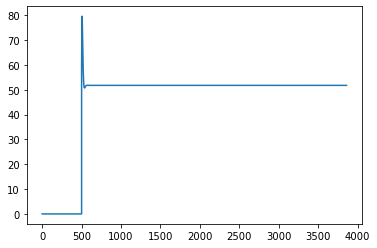

In [64]:
fig, ax = plt.subplots()
ax.plot(df_data2.Time[:300], df_data2.Valve_Positions[:300]);

In [49]:
# Create a test data set
X_test = df_data2.drop("Valve_Positions", axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           9021 non-null   float64
 1   Input          9021 non-null   float64
 2   Liquid_levels  9021 non-null   float64
 3   Feedback       9021 non-null   float64
dtypes: float64(4)
memory usage: 282.0 KB


In [51]:
y_preds = model.predict(X_test)

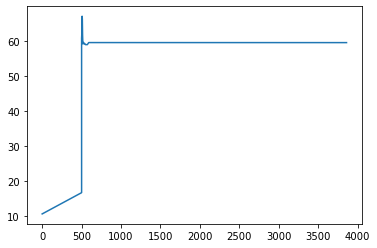

In [62]:
fig, ax = plt.subplots()
ax.plot(df_data2.Time[:300], y_preds[:300]);